# Spike Time Dependent Plasticity
## Basic Experiments

In this notebook I'm going to implement some basic experiments related to the STDP algorithm from scratch.

The outline for this notebook is the following:
- Prelimainaries
    - Generic function for simulations
    - Default parameters
    - Plot utils
- Simple neurons models:
    - LIF neuron 
    - Poisson Neuron Model
- STDP algorithms
    - general simulation
    - STDP rule
- Turn the screw on STDP
    - ...
    - ...

In [338]:
%load_ext autoreload
%autoreload 2
# basic libraries
import os
import sys
import shutil
import time
import numpy as np

# graphics libraries
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format='retina'
# use NMA plot style
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
plt.style.use('seaborn-v0_8')
my_layout = widgets.Layout()
my_layout.width = '620px'

#import from my scripts
main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)
import importlib

importlib.reload(importlib.import_module('neurons'))
importlib.reload(importlib.import_module('learning_rules'))
from neurons import *
from learning_rules import *

# show packages versions for python, numpy, and ipywidgets
print("Python: ", sys.version)
print("Numpy: ", np.__version__)
print("IPywidgets: ", widgets.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Numpy:  1.25.2
IPywidgets:  8.0.4


# Framework 

## Simulations on simple networks

I start by writing a function to study a given neuron type and a given weight update rule. I'm working with a network with `N_pre` presynaptic neuron (whose spike trains are controlled) and 1 post synaptic neuron.

In [339]:
def base_simulation(
        pars,
        spk_input, # input spike train, a numpy vector of shape (time_steps, N_pre)
        neuron_type, # class for the neuron type
        weight_update = None, # function for the weight update
        N_pre = 100, # number of pre-synaptic neurons
        W_init = None, # initial weights
        neuron_params = {}, # parameters for the neuron model
        weight_update_params = {}, # parameters for the weight update
):

    num_steps = np.shape(spk_input)[0]

    # Initialize the arrays for spikes, membrane potential and weights recording 
    post_spk_train = np.zeros((num_steps,1))
    post_mem_record = np.zeros((num_steps,1))
    weights_history = np.zeros((num_steps+1, 1, N_pre))

    my_lif = neuron_type(pars, **neuron_params)

    # Initialize the weights
    if W_init is None:
        W_init = np.random.rand(1,N_pre)
    else:
        assert np.shape(W_init)[1] == N_pre, 'W must have the same number of rows as the number of pre-synaptic neurons'

    weights_history[0, :] = W_init

    # object to keep track of variables
    traces = None
    W = W_init
    I_history = np.zeros((num_steps, 1))

    for t in range(num_steps):
        pre_syn_spikes = spk_input[t,:] # spikes from the pre-synaptic neurons at time t
        
        # compute the input current for the neuron
        #I = np.dot(pre_syn_spikes, W[:,0])
        I = (W @ pre_syn_spikes)[0]
        
        #record the history of input current for the neuron
        I_history[t] = I

        # run the neuron model
        mem, spk = my_lif.forward(I)
        post_spk_train[t,0] = spk
        post_mem_record[t,0] = mem

        # update the weights
        if weight_update is not None:
            spikes = [pre_syn_spikes, spk]
            W, traces = weight_update(pars, W, traces, spikes, **weight_update_params)
        else:
            W = W

        # store the weights
        weights_history[t+1, :] = W
          
    return weights_history, post_spk_train, post_mem_record, I_history, my_lif



This function generalizes the previous one allowing for multiple postsynaptic neurons `N_post`. In additions it also include the presynaptic layer explicitely.

In [340]:
def FC_simulation(
        pars,
        N_pre,
        N_post,
        I_inj, # input spike train, a numpy vector of shape (time_steps, N_pre)
        neuron_type, # function for the type of neuron 
        weight_update = None, # function for the weight update
        W_init = None, # initial weights
        neuron_params = {}, # parameters for the neuron model
        weight_update_params = {}, # parameters for the weight update
):
    
    num_steps = np.shape(I_inj)[0]

    # Initialize the arrays for spikes, membrane potential and weights recording
    pre_spk_train = np.zeros((num_steps, N_pre)) 
    post_spk_train = np.zeros((num_steps, N_post))
    pre_mem_record = np.zeros((num_steps, N_pre))
    post_mem_record = np.zeros((num_steps, N_post))
    I_post_inj = np.zeros((num_steps, N_post))
    weights_history = np.zeros((num_steps+1, N_post, N_pre))


    # Initialize the weights
    if W_init is None:
        W_init = np.random.rand(N_post,N_pre)
    else:
        assert np.shape(W_init) == (N_post,N_pre), 'W must have the shape (N_post, N_pre)'

    weights_history[0,:,:] = W_init

    # initialize some 
    traces = None
    W = W_init

    # start the simulation
    for t in range(num_steps):

        # pass the injected current to the pre_synaptic neurons
        for j in range(N_pre):
            if t>1:
                pre_mem, pre_spk = neuron_type(pars, I_inj[t,j], mem = pre_mem_record[t-1,j], **neuron_params)
            else:
                pre_mem, pre_spk = neuron_type(pars, I_inj[t,j], **neuron_params)
            pre_spk_train[t,j] = pre_spk
            pre_mem_record[t,j] = pre_mem

        # compute the input current for the post-synaptic neurons
        I_post = W @ pre_spk_train[t,:] # spikes from the pre-synaptic neurons at time t
        #print(I_post)
        I_post_inj[t,:] = I_post

        # pass the current to the post-synaptic neurons
        for i in range(N_post):
            if t>1:
                post_mem, post_spk = neuron_type(pars, I_post[i], mem = post_mem_record[t-1,i], **neuron_params)
            else:
                post_mem, post_spk = neuron_type(pars, I_post[i], **neuron_params)
            post_spk_train[t,i] = post_spk
            post_mem_record[t,i] = post_mem


        # update the weights
        if weight_update is not None:
            spikes = [pre_spk_train[t,:], post_spk_train[t,:]]
            W, traces = weight_update(pars, W, traces, spikes, **weight_update_params)
        else:
            W = W

        # store the weights
        weights_history[t+1,:,:] = W

    return weights_history, pre_spk_train, post_spk_train, pre_mem_record, post_mem_record, I_post_inj



## Default parameters for the models

These are the parameters coming from neuroscience studies.

In [341]:
def default_pars(**kwargs):
    '''
    Define the default parameters
    values come from COURSE 2 
    '''

    pars = {}

    # typical neuron parameters
    pars['threshold'] = -55.    # spike threshold [mV]
    pars['tau_m'] = 10.         # membrane time constant [ms]
    pars['R'] = 0.1            # leak resistance [Ohm] with this resistance input current must be of the order of 100 mV
    pars['U_init'] = -65.       # initial potential [mV]
    pars['U_reset'] = -75.      # reset potential [mV]
    pars['U_resting'] = -75.    # leak reversal potential [mV]
    pars['t_ref'] = 5.          # refractory time (ms)

    # in the case of dynamic threshold
    pars['tau_thr'] = 5         # threshold time constant [ms]
    pars['ratio_thr'] = 1.1     # relative increment in the threshold due to a spike

    # in the case of soft reset
    ## ?? some way to lower the membrane potential not to a constant value
    
    # in case of noisy input
    pars['sigma'] = 1         # standard deviation of the noise

    # random seed
    pars['my_seed'] = 42

    # time steps
    pars['dt'] = 0.1             # simulation time step [ms]

    # for Poisson models
    pars['alpha'] = 0.1          # scaling factor for the membrane to the rate

    # STDP parameters
    pars['A_plus'] = 0.008                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD 
    pars['tau_plus'] = 20                    # LTP time constant [ms]
    pars['tau_minus'] = pars['tau_plus']     # LTD time constant [ms]

    # weight parameters
    pars['Wmax'] = 1.            # maximum weight
    pars['Wmin'] = 0.            # minimum weight


    # external parameters if any #
    for k in kwargs:
        pars[k] = kwargs[k]

    return pars


pars = default_pars()

These are the parameters we hope to use.

In [342]:
def simple_pars(**kwargs):
    '''
    Define the default parameters
    values come from COURSE 2 
    '''

    pars = {}

    # typical neuron parameters
    pars['threshold'] = 1.    # spike threshold [mV]
    pars['tau_m'] = 10.         # membrane time constant [ms]
    pars['R'] = 1            # leak resistance [Ohm] with this resistance input current must be of the order of 100 mV
    pars['U_init'] = 0       # initial potential [mV]
    pars['U_reset'] = 0.      # reset potential [mV]
    pars['U_resting'] = 0.    # leak reversal potential [mV]
    pars['t_ref'] = 2.          # refractory time (ms)

    # in the case of dynamic threshold
    pars['tau_thr'] = 5         # threshold time constant [ms]
    pars['ratio_thr'] = 1.1     # relative increment in the threshold due to a spike

    # in the case of soft reset
    ## ?? some way to lower the membrane potential not to a constant value

    # random seed
    pars['my_seed'] = 42

    # time steps
    pars['dt'] = 1             # simulation time step [ms]

    # for Poisson models
    pars['alpha'] = 0.1          # scaling factor for the membrane to the rate

    # STDP parameters
    pars['A_plus'] = 0.008                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD 
    pars['tau_plus'] = 20                    # LTP time constant [ms]
    pars['tau_minus'] = pars['tau_plus']     # LTD time constant [ms]

    # weight parameters
    pars['Wmax'] = 1.            # maximum weight
    pars['Wmin'] = 0.            # minimum weight


    # external parameters if any #
    for k in kwargs:
        pars[k] = kwargs[k]

    return pars

s_pars = simple_pars()

## Plot utilis

Here I group the functions to plot the graphics/interactive demos given a simulation.

First a basic raster plot for the input and output neurons.


In [343]:
# we are plotting the case in which we have the input spikes equal to the injected current
def raster_plot(
        pars, # parameters
        pre_syn_spk, # input spikes as array of 0,1 of shape (time_steps, N_pre) or as list of spike times
        post_syn_spk, # output spikes as array of 0,1 of shape (time_steps, N_post) or as list of spike times
        title = 'Raster plot'):
    
    """
    function to plot the raster plot of the input and output spikes
    INPUTS:
    - pars: parameters of the simulation
    - pre_syn_spk: input spikes as array of 0,1 of shape (time_steps, N_pre) or as list of spike times
    - post_syn_spk: output spikes as array of 0,1 of shape (time_steps, N_post) or as list of spike times
    - title: title of the plot
    """


    dt=pars['dt']

    # useful values
    N_pre = np.shape(pre_syn_spk)[1]
    N_post = np.shape(post_syn_spk)[1]
    time_steps = np.shape(pre_syn_spk)[0]

    # Generate Plots
    height_ratio = int(min(N_pre/ N_post,10))
    fig, ax = plt.subplots(2, figsize=(15,10), sharex=True, gridspec_kw = {'height_ratios': [height_ratio,1]})


    # convert spike record in spike times
    if type(pre_syn_spk) is list:
        pre_syn_spk_times = pre_syn_spk
    else:
        # note: even with 10000 presynaptic neurons and 10000 time steps this is not an heavy operation
        pre_syn_spk_times = [np.array(np.where(pre_syn_spk[:,i]==1)[0])*dt for i in range(N_pre)]
        
    ax[0].eventplot(pre_syn_spk_times, colors='black', lineoffsets=1,linewidth=1, linelengths=0.8, orientation='horizontal')
    # set y axis ticks corresponding to the neurons
    ax[0].set_yticks(np.arange(0, len(pre_syn_spk_times)+1, round(N_pre/10)))
    ax[0].set_ylabel("Input Spikes")
    ax[0].set_title(title)


    # Plot output spikes
    if type(post_syn_spk) is list:
        post_syn_spk_times = post_syn_spk
    else:
        post_syn_spk_times = [np.array(np.where(post_syn_spk[:,i]==1)[0])*dt for i in range(N_post)]
    ax[1].eventplot(post_syn_spk_times, colors='black', lineoffsets=1,linewidth=1, linelengths=0.8, orientation='horizontal')   
    ax[1].set_yticks(np.arange(0, N_post, max(round(N_post/10),1)))
    ax[1].set_ylabel("Output Spikes")
    ax[1].set_xlabel("Time (ms)")

    plt.show()

This is a function to analyse a single neuron during time.

In [344]:
def plot_cur_mem_spk(
          cur,             # input current during the simulation
          mem,             # membrane potential during the simulation
          spk,             # spike records from the neuron
          dt=0.1,          # time step for the simulation
          thr_line=False,  # threshold line
          vline=False, 
          title=False,
          ylim_max2=1.25):
    
    number_of_steps = len(cur)
    T = number_of_steps*dt
    time = np.arange(0, number_of_steps*dt, dt)
    # Generate Plots
    fig, ax = plt.subplots(3, figsize = (10, 8), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

    # Plot input current
    ax[0].plot(time,cur, c="tab:orange")
    #ax[0].set_ylim([0, 0.4])
    #ax[0].set_xlim([0, 200])
    ax[0].set_ylabel("Input Current ($I_{in}$)")
    if title:
        ax[0].set_title(title)

    # Plot membrane potential
    ax[1].plot(time, mem)
    #ax[1].set_ylim([0, ylim_max2])
    ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
    if thr_line:
        ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
    plt.xlabel("Time (ms)")

    # Plot output spike using spikeplot
    #ax[2].plot(time,spk, c="black", marker="|", linestyle='None', markersize=20, markeredgewidth=1.5)
    #ax[2].set_ylim([0.5, 1.5])
    ax[2].eventplot(np.array(np.where(spk==1))*dt, color="black", linelengths=0.5)
    plt.ylabel("Output spikes")
    plt.yticks([])

    plt.show()

This is an interactive plot to show the changes in weights during the simulation and their distribution.

In [345]:
def weights_plot(weights_history,time_step):
    """
    Plot the weights changes during the simulation

    INPUT:
    - pars: parameter dictionary
    - weights_history: synaptic weights over time for one post_synaptic neuron
    - spk_out: spike train of the post-synaptic neuron

    RETURN:
    Interactive demo, Visualization of synaptic weights
    """
    
    N_pre = weights_history.shape[1]
    num_steps = weights_history.shape[0]
    time_steps = np.arange(0, num_steps, 1)

    if time_step > num_steps:
        print(f'Time step must be less than {num_steps}')
        return
    
    subsampling = 100

    fig,ax = plt.subplots(2, figsize=(8, 8))
        
    for i in range(N_pre):
        ax[0].plot(time_steps[::subsampling], weights_history[ ::subsampling,i], lw=1., alpha=0.7)

    ax[0].axvline(time_step, 0., 1., color='k', ls='--')
    #ax[0].set_ylim(0, 0.025)
    #ax[0].set_xlim(-2, 122)
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel(r'Weight')

    w_min = np.min(weights_history[time_step,:])-0.1
    w_max = np.max(weights_history[time_step,:])+0.1
    width = (w_max - w_min)/50
    bins = np.arange(w_min, w_max, width)
    g_dis, _ = np.histogram(weights_history[time_step,:], bins)
    ax[1].bar(bins[1:], g_dis, color='b', alpha=0.5, width=0.01)
    ax[1].set_xlabel('weights ditribution')
    ax[1].set_ylabel('Number')
    ax[1].set_title(f'Time step: {time_step}')
    plt.show()

# Simple Neuron Models

I'll start implementing the neurons as python functions, therefore I'll move to class syntax. 

## LIF neuron

We can see the overall raster plot.

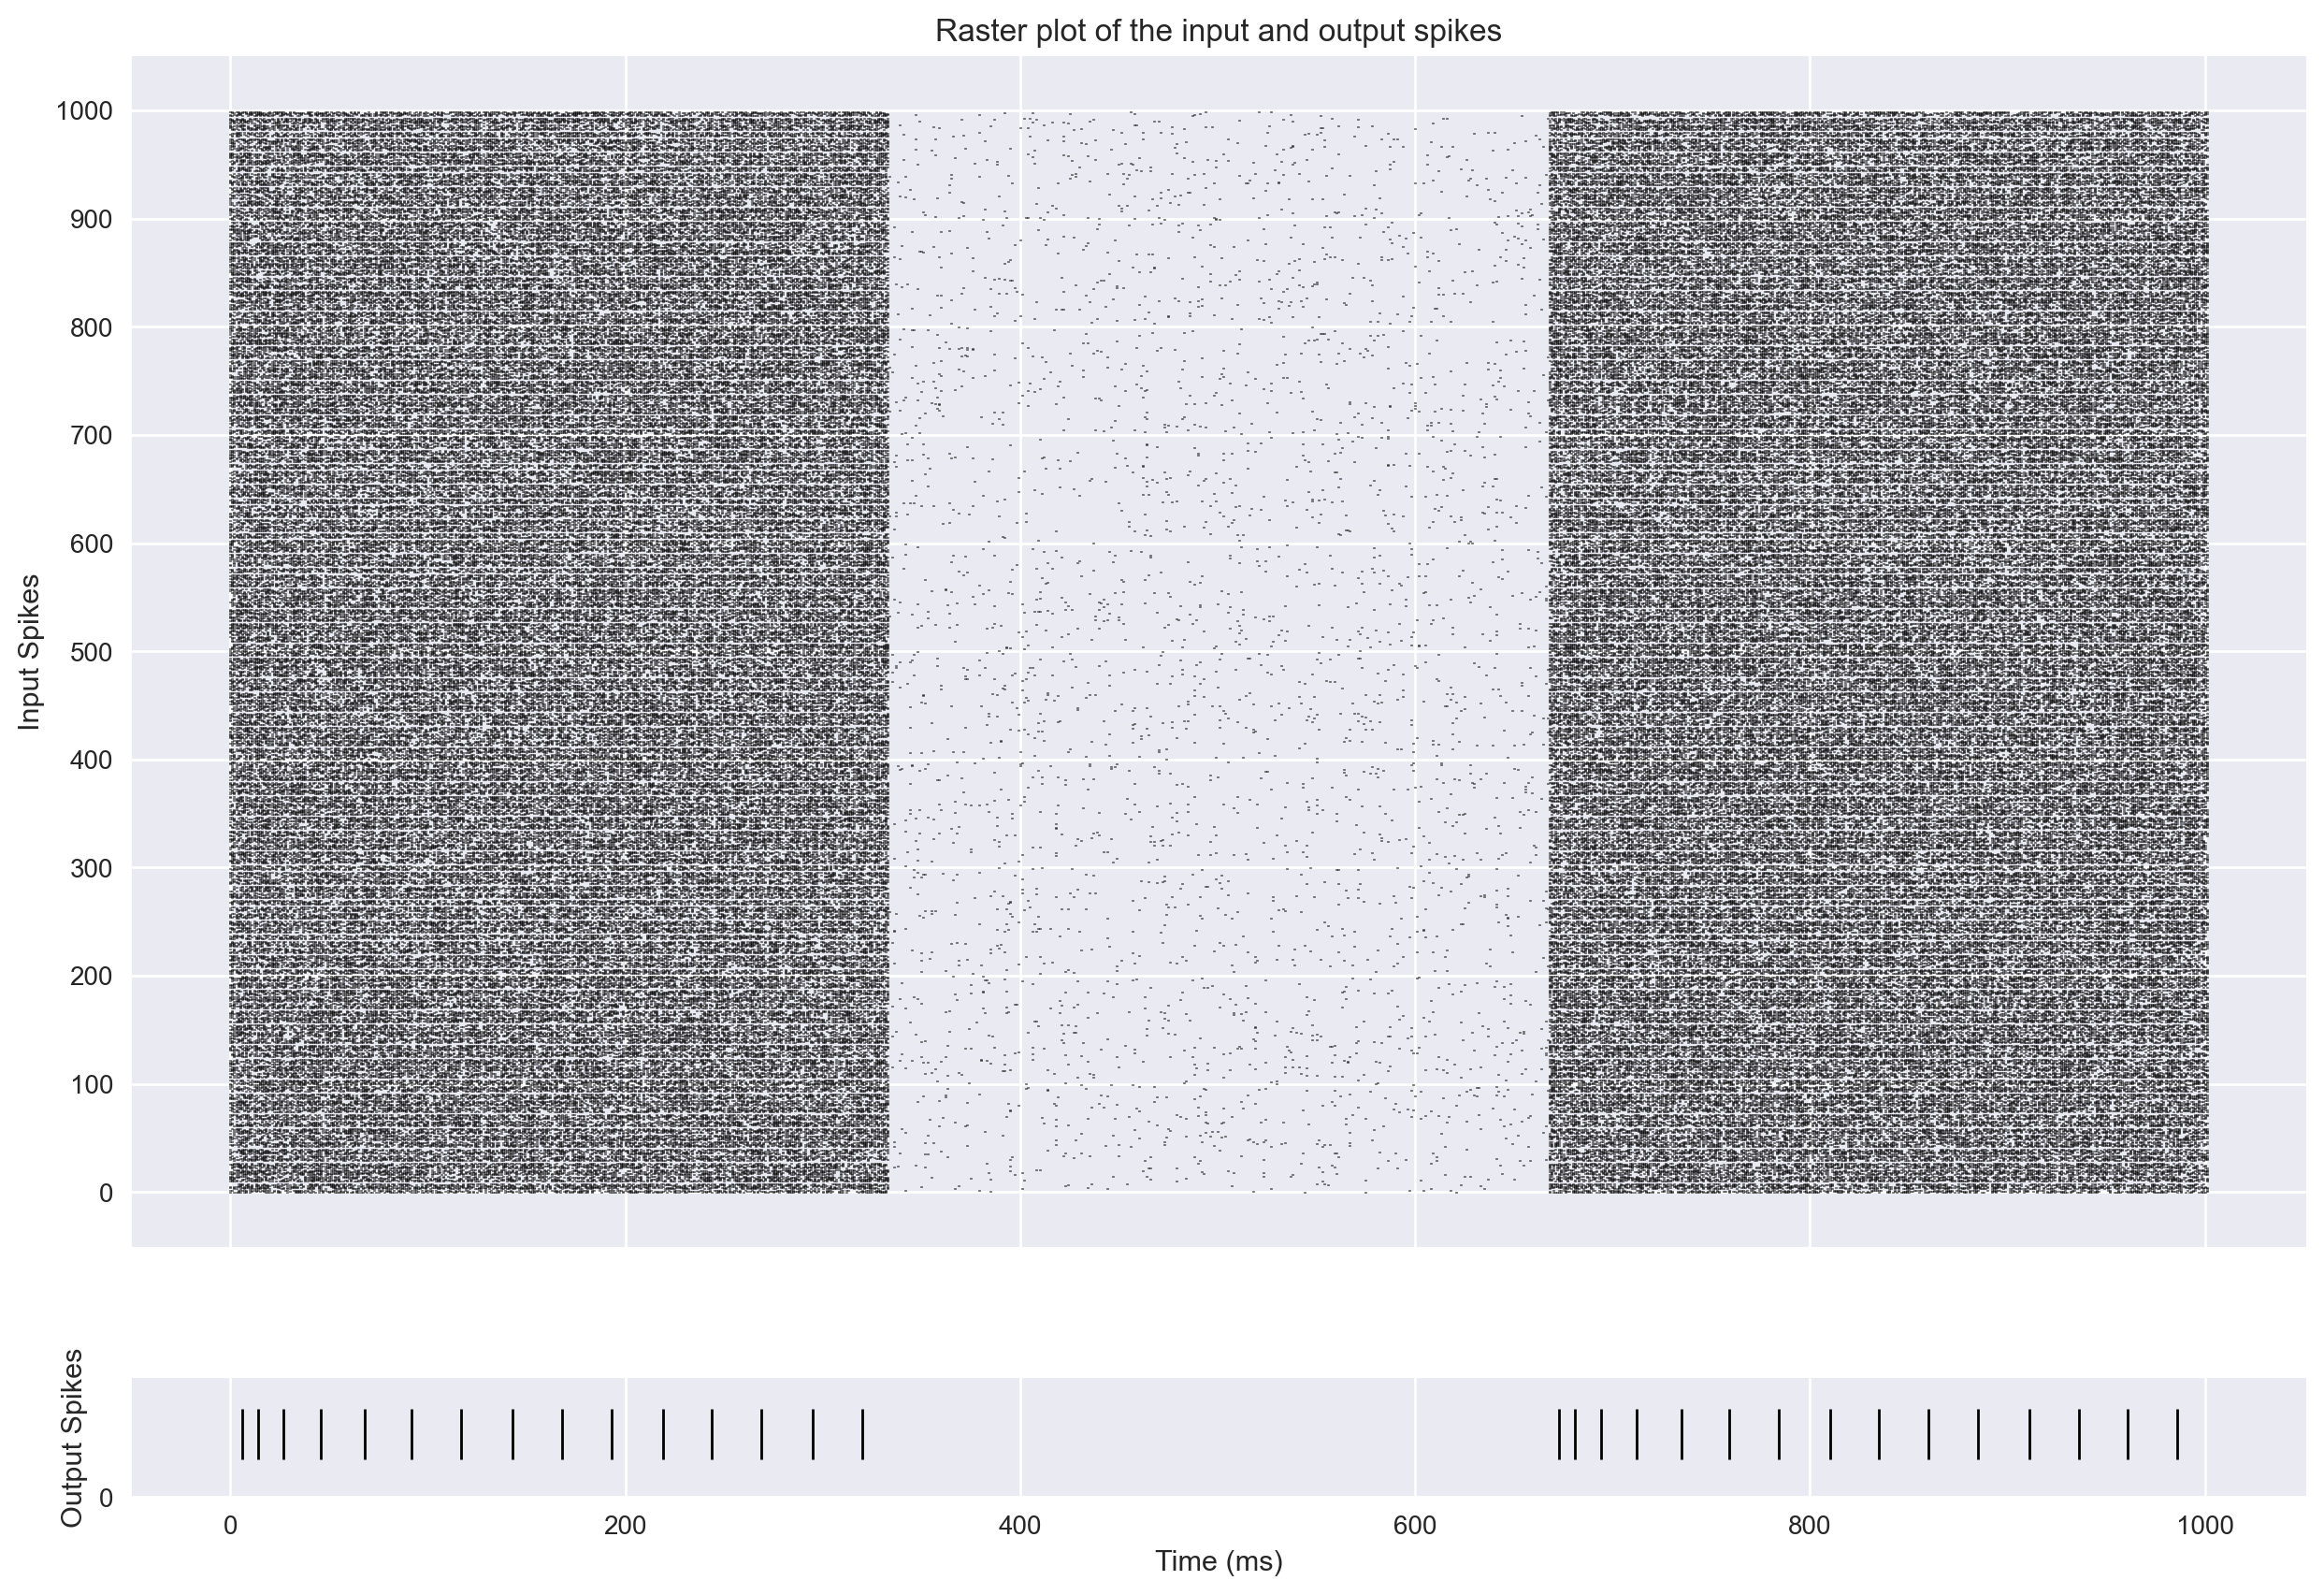

In [346]:
N_pre = 1000
time_steps = 1002 # that is 100 milliseconds
#I = np.ones((time_steps,N_pre))
I = np.concatenate([np.round(np.random.random((time_steps//3,N_pre))), np.round(np.random.random((time_steps//3,N_pre))-0.49),np.round(np.random.random((time_steps//3,N_pre)))], axis=0) 

# random spike train with spike probability 0.5 in the first half and 0.2 in the second half#
#pars = default_pars()
pars = simple_pars(ratio_thr = 1.5, t_ref=5, tau_thr = 40)
_, post_spk_train, post_mem_record, I_history, neuron = base_simulation(pars, I, LIFNeuron, N_pre=N_pre, W_init=np.random.random((1,N_pre))*0.01, 
                                                                           neuron_params = {'refractory_time': False, 'dynamic_threshold': True, 'hard_reset':True})


raster_plot(pars, I, post_spk_train, title = 'Raster plot of the input and output spikes')

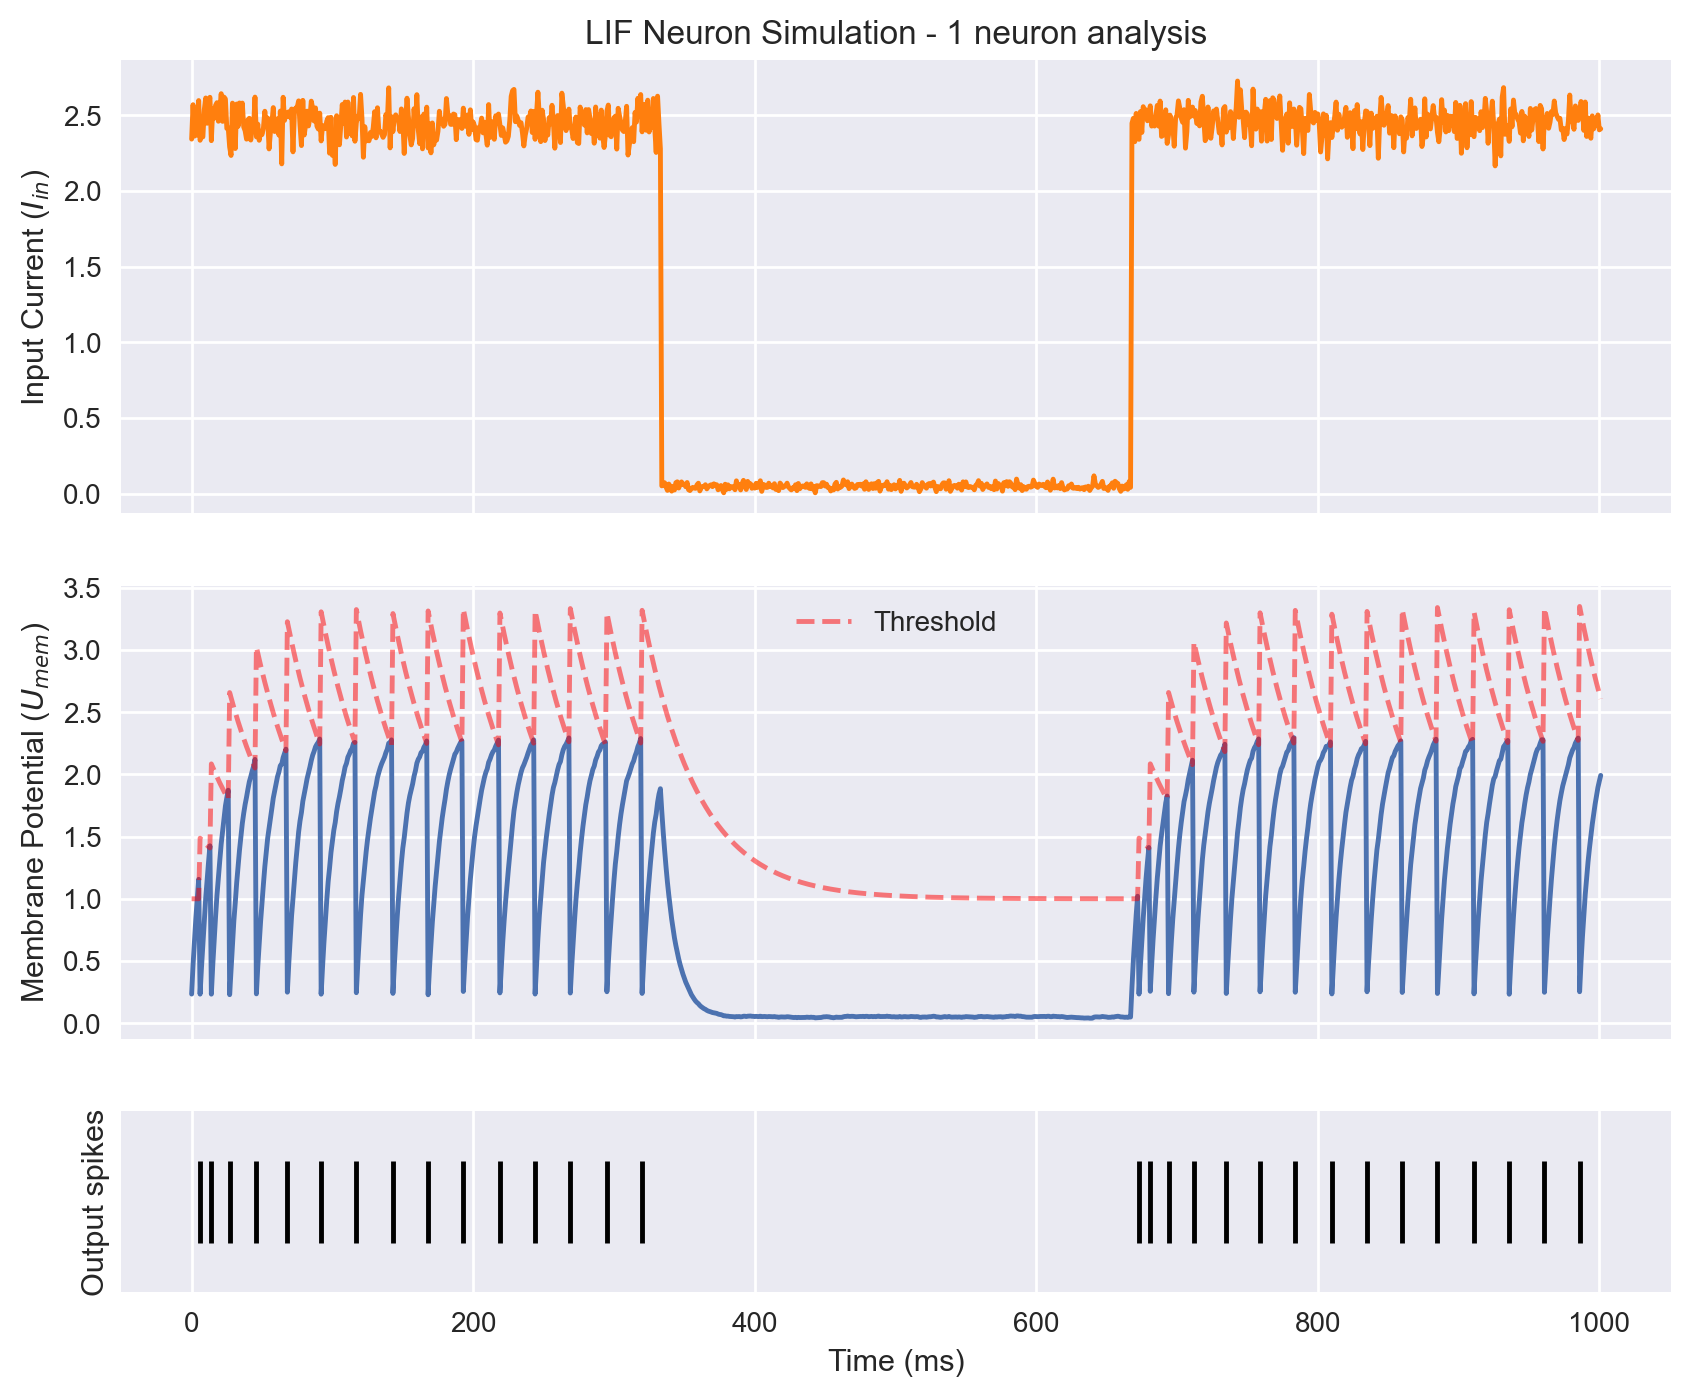

In [347]:
neuron.plot_records(title="LIF Neuron Simulation - 1 neuron analysis")

and also the specific behavior of the output neuron.

## Poisson Neuron Model

First we will need a function to generate Poisson Spike Trains.

In [348]:
def Poisson_generator(pars, rate, n, num_steps, myseed=False):
    """Generates poisson trains

    Args:
    pars            : parameter dictionary
    rate            : noise amplitute [Hz] constant in time
    n               : number of Poisson trains (N_pre)
    myseed          : random seed. int or boolean

    Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                        there is a spike in ith spike train over time
                        (1 if spike, 0 otherwise)
    """

    # Retrieve simulation parameters
    dt = pars['dt']

    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate uniformly distributed random variables
    u_rand = np.random.rand(num_steps, n)

    # generate Poisson train
    rate_per_bin = rate * (dt / 1000.)
    poisson_train = 1. * (u_rand < rate_per_bin)

    return poisson_train


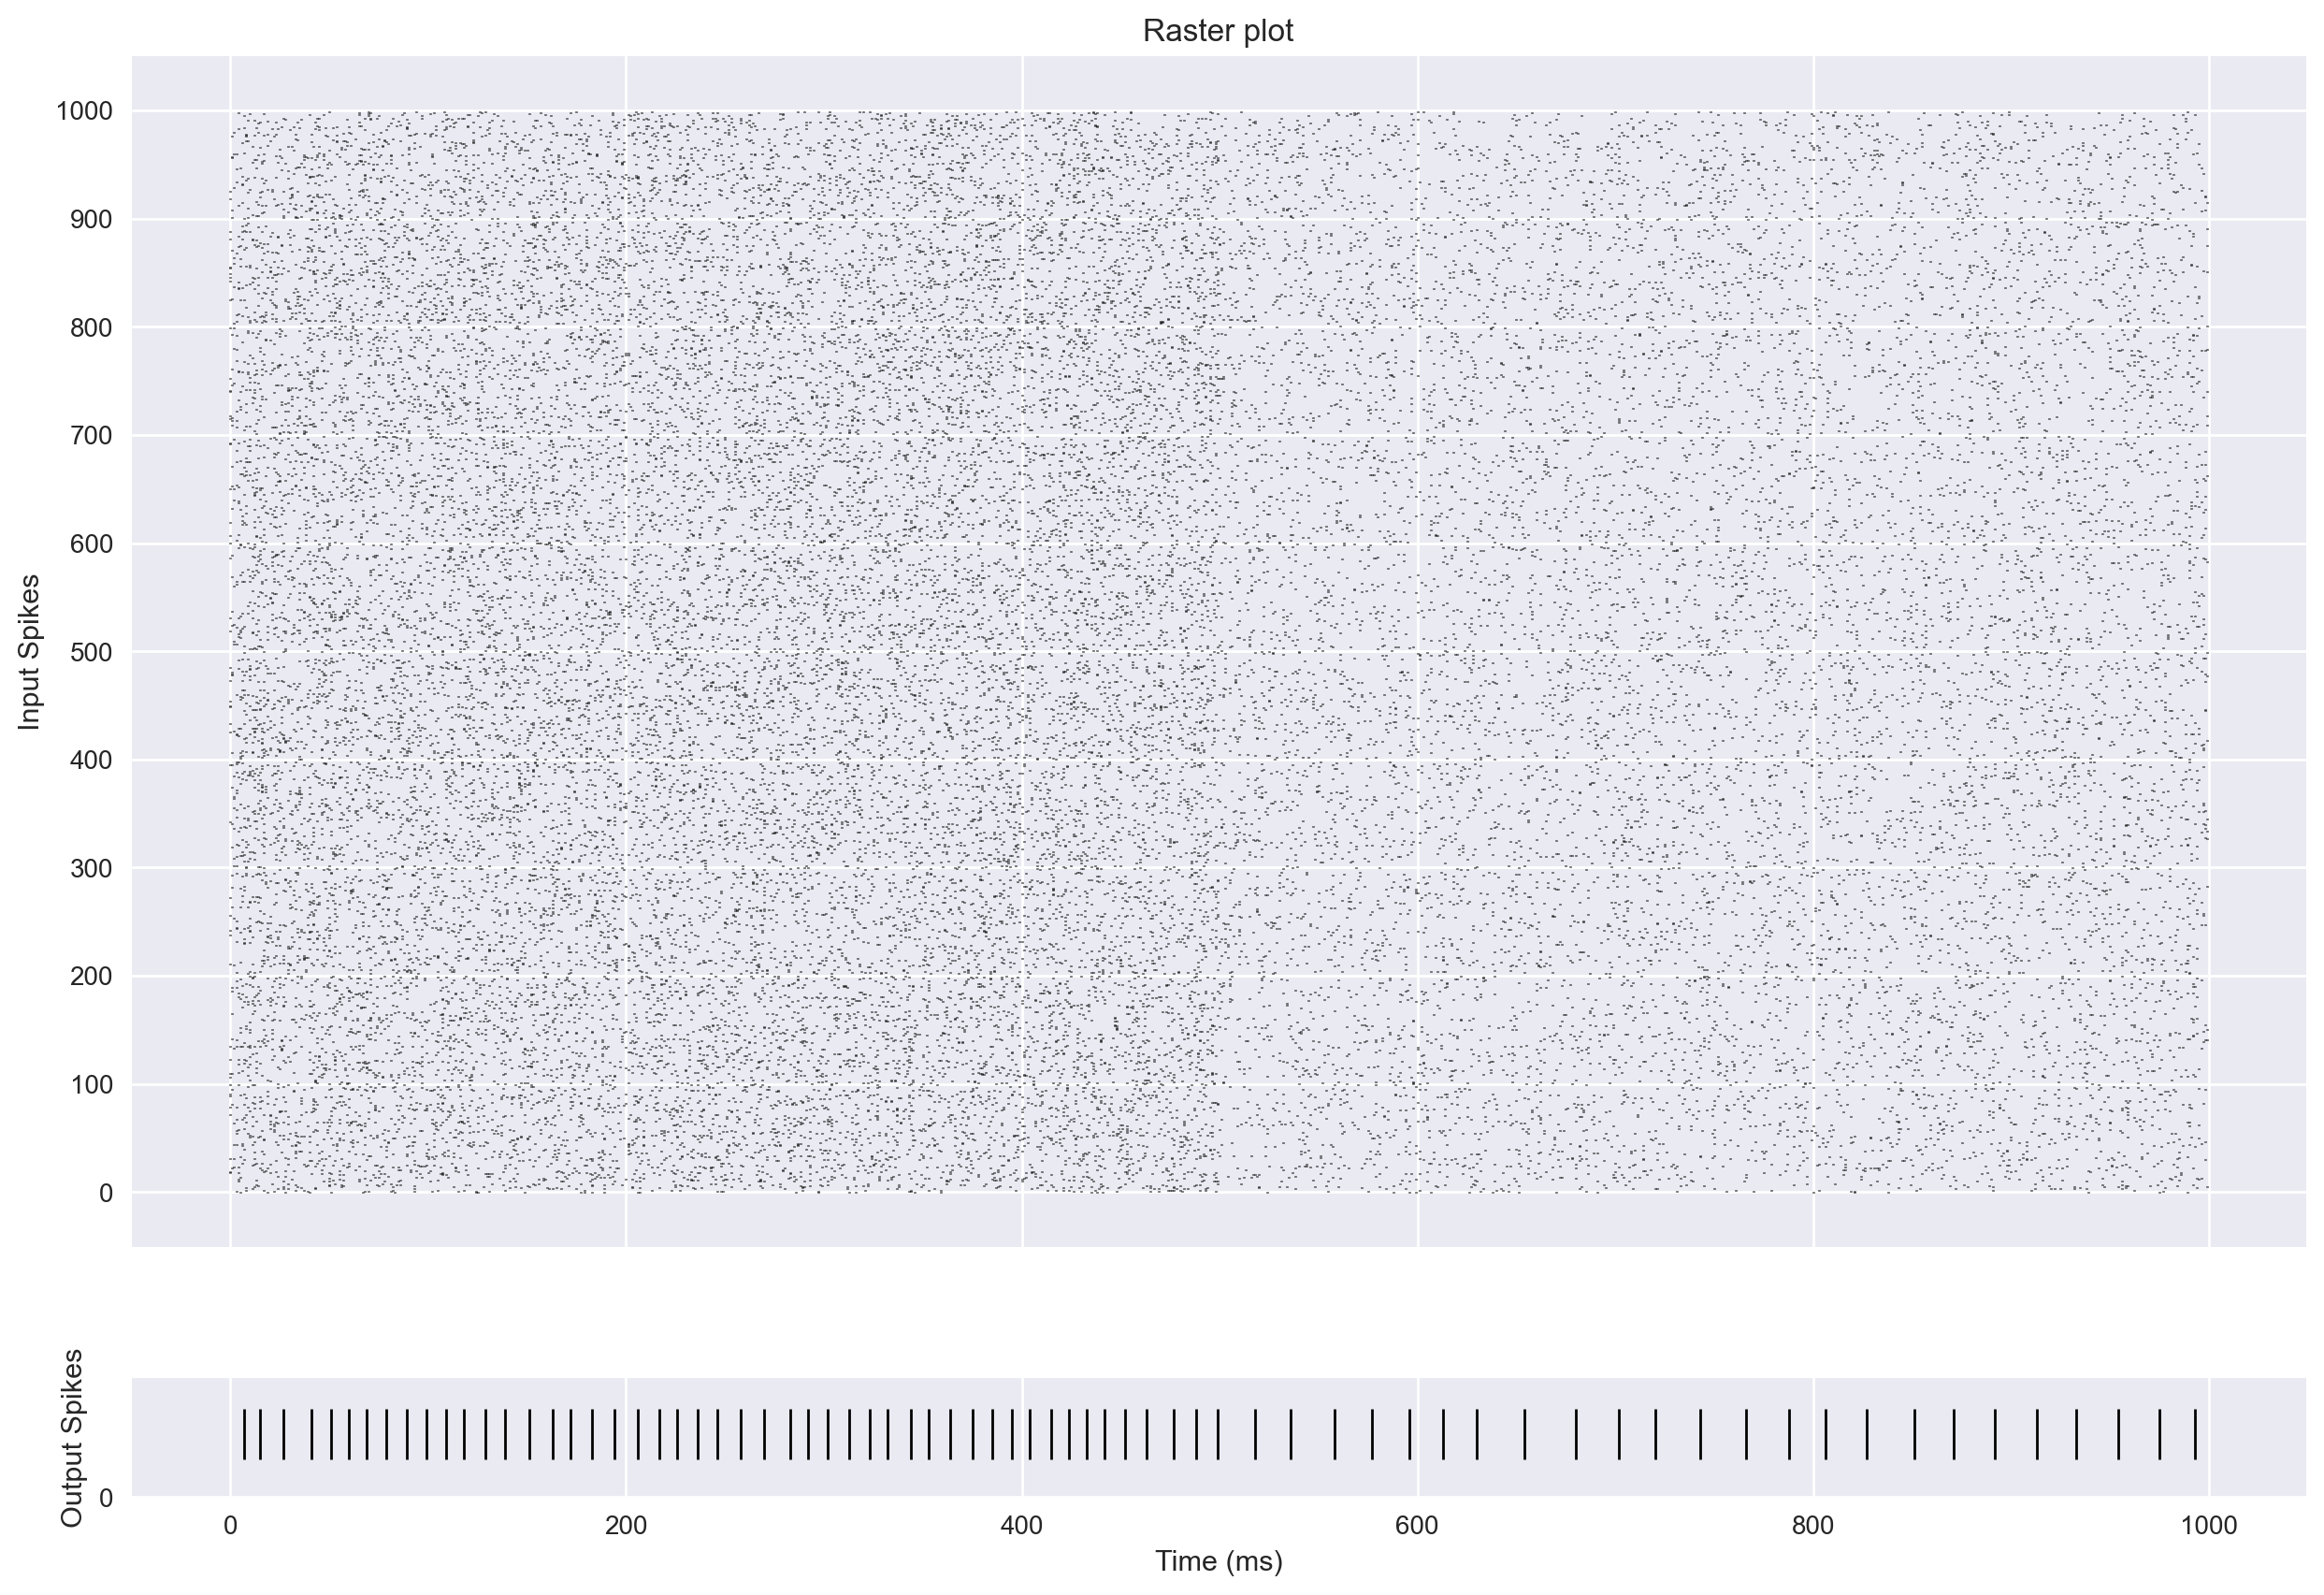

In [349]:
# simple Poisson simulation and plot
N_pre = 1000
time_steps = 1000 # that is 100 milliseconds
pars = default_pars()
#pars = simple_pars()
rate = 500
I = np.concatenate([Poisson_generator(pars, rate, N_pre, time_steps//2), Poisson_generator(pars, rate/2, N_pre, time_steps//2)], axis=0) 
# random spike train with spike probability 0.5 in the first half and 0.2 in the second half

_, post_spk_train, post_mem_record, I_history, neuron = base_simulation(pars, I, PoissonNeuron, N_pre=N_pre, W_init=np.random.random((1,N_pre))*100)
raster_plot(s_pars, I, post_spk_train)


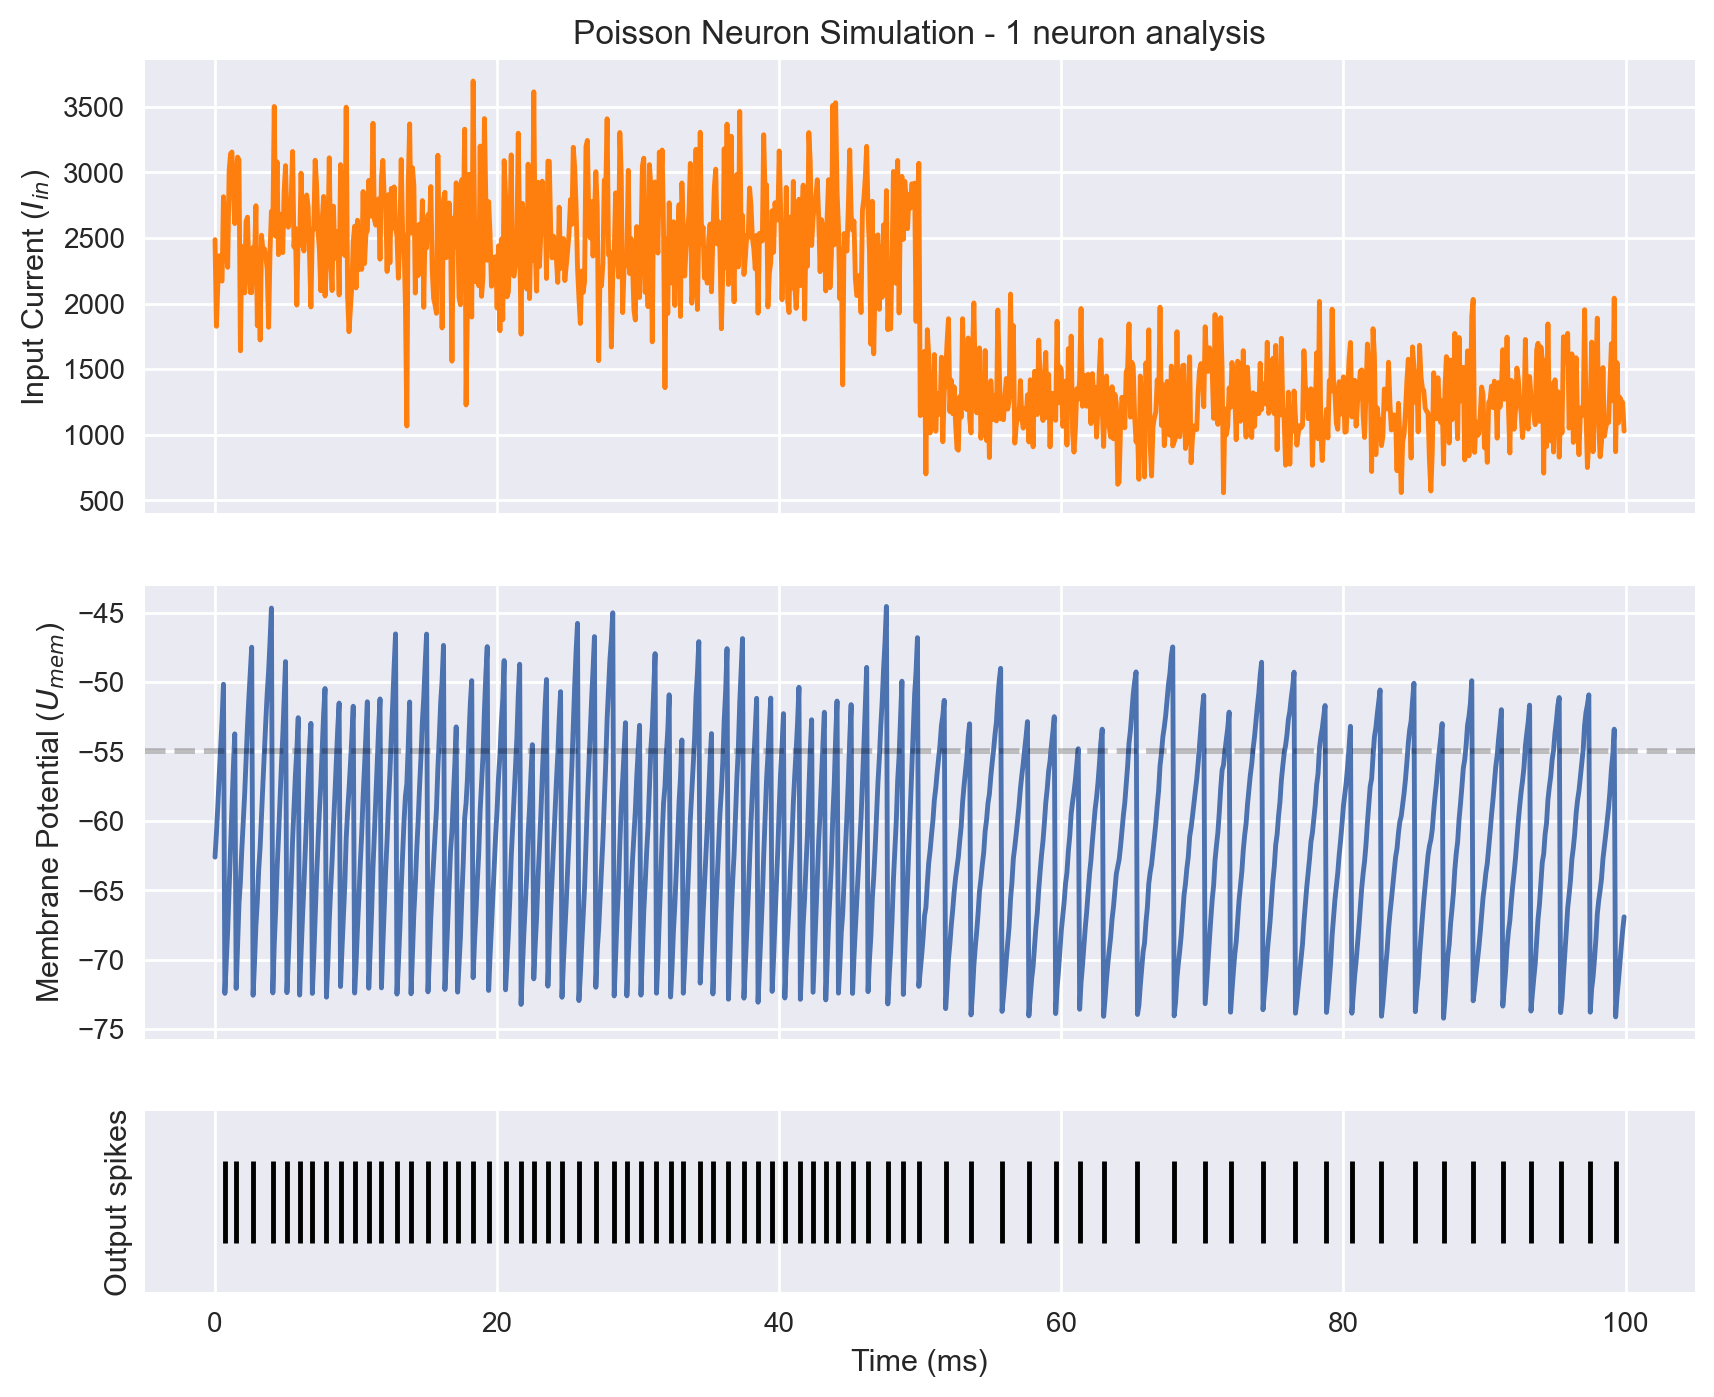

In [350]:
plot_cur_mem_spk(I_history, post_mem_record[:,0], post_spk_train[:,0], thr_line=pars['threshold'], title="Poisson Neuron Simulation - 1 neuron analysis")

# Spike time based algorithms

We now can implement the STDP update rule, which relies on the pre and post synaptic traces of the neurons.

In [351]:
N_pre = 300
num_steps = 10000 # that is 100 milliseconds
I = np.concatenate([np.round(np.random.random((num_steps//2,N_pre))), np.round(np.random.random((num_steps//2,N_pre))-0.3)], axis=0) 
inputrate = 15.
pars = default_pars()
s_pars = simple_pars()
I = Poisson_generator(s_pars, rate=inputrate, n=300, num_steps = num_steps)#, myseed=2020)
# random spike train with spike probability 0.5 in the first half and 0.2 in the second half

weights_history, spk_out, mem_out, I_history, neuron = base_simulation(pars, I, LIFNeuron, N_pre=N_pre, weight_update = STDP_rule, W_init=np.ones((1,N_pre))*2000)


widgets.interact(weights_plot, 
                 weights_history=fixed(weights_history),
                 time_step=widgets.IntSlider(
                     value = 0, 
                     min=0, 
                     max=num_steps, 
                     step=num_steps//100,
                     description = 'Time [ms]',
                     layout=my_layout),
                 )


#weigths_plot(1000,weights_history=weights_history[:,0,:])



interactive(children=(IntSlider(value=0, description='Time [ms]', layout=Layout(width='620px'), max=10000, ste…

<function __main__.weights_plot(weights_history, time_step)>

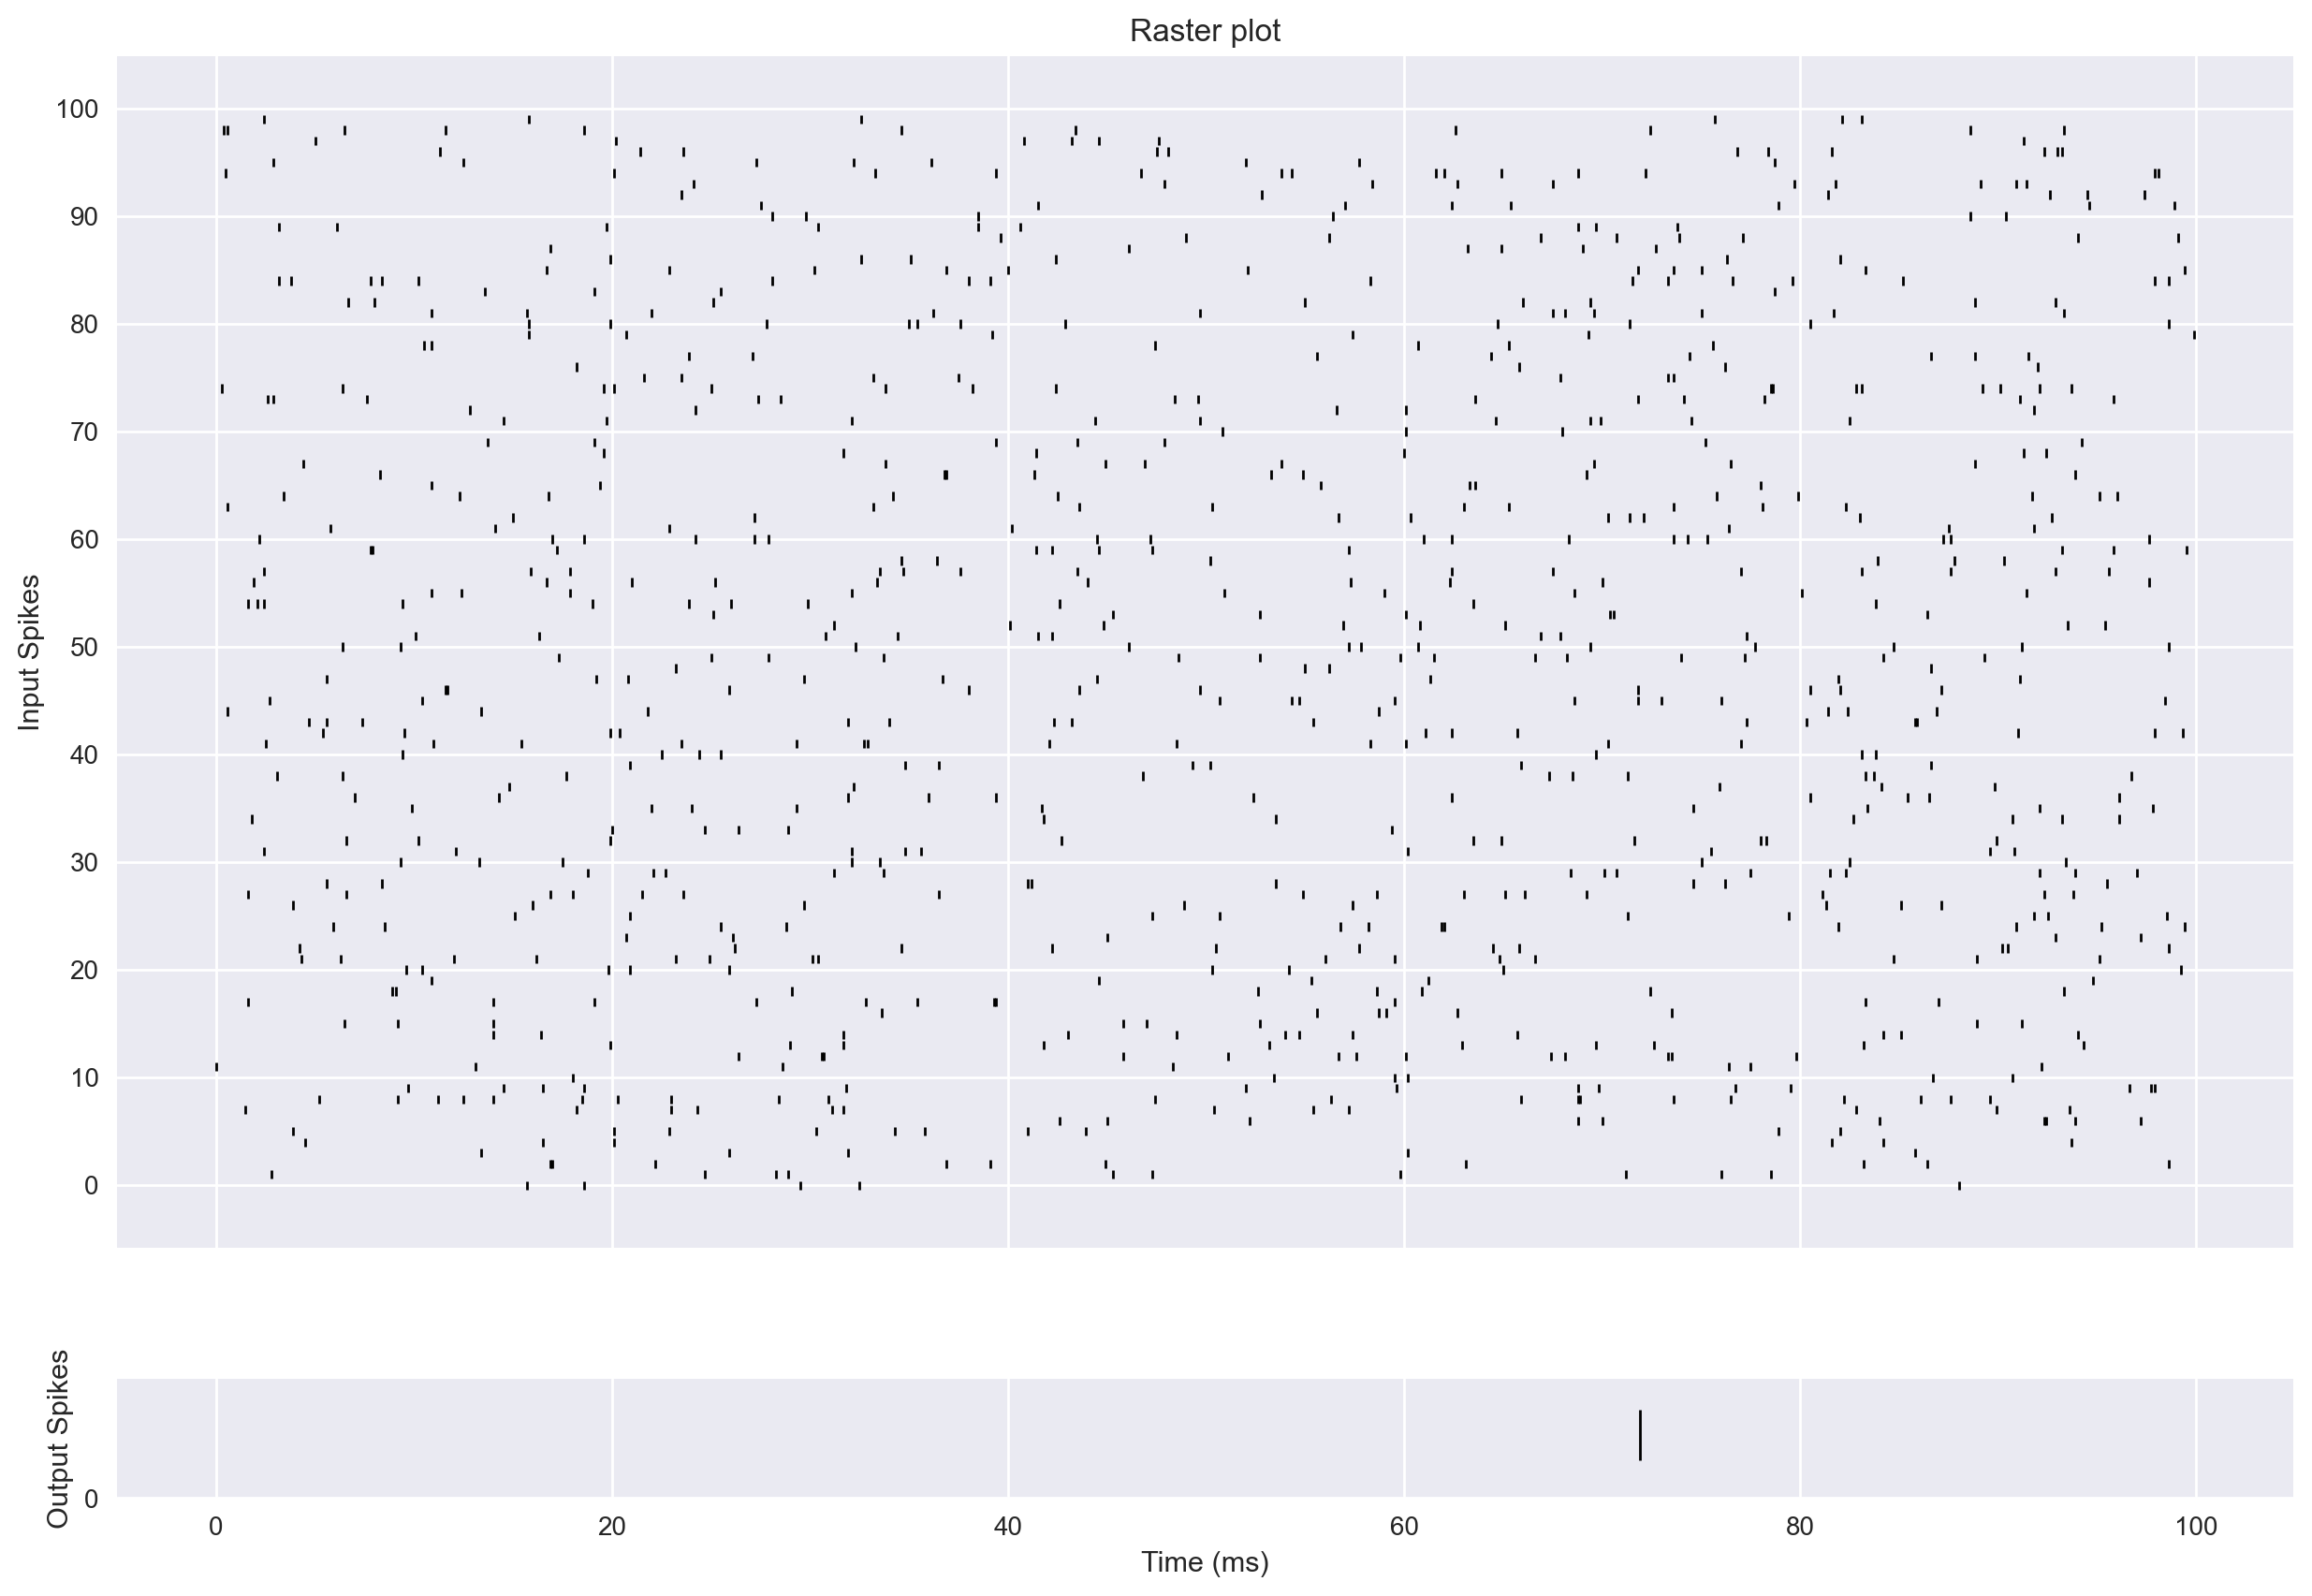

In [352]:
# simple STDP simulation and plot
N_pre = 100
time_steps = 1000 # that is 100 milliseconds
rate = 100
pars = default_pars()
I = Poisson_generator(pars, rate, N_pre, time_steps)
weights_history, spk_out, mem_out, I_history, neuron = base_simulation(pars, I, LIFNeuron, N_pre=N_pre, weight_update = STDP_rule, W_init=np.ones((1,N_pre))*200)
raster_plot(pars,I, spk_out)
#weights_history_plot(weights_history[:,0,:])


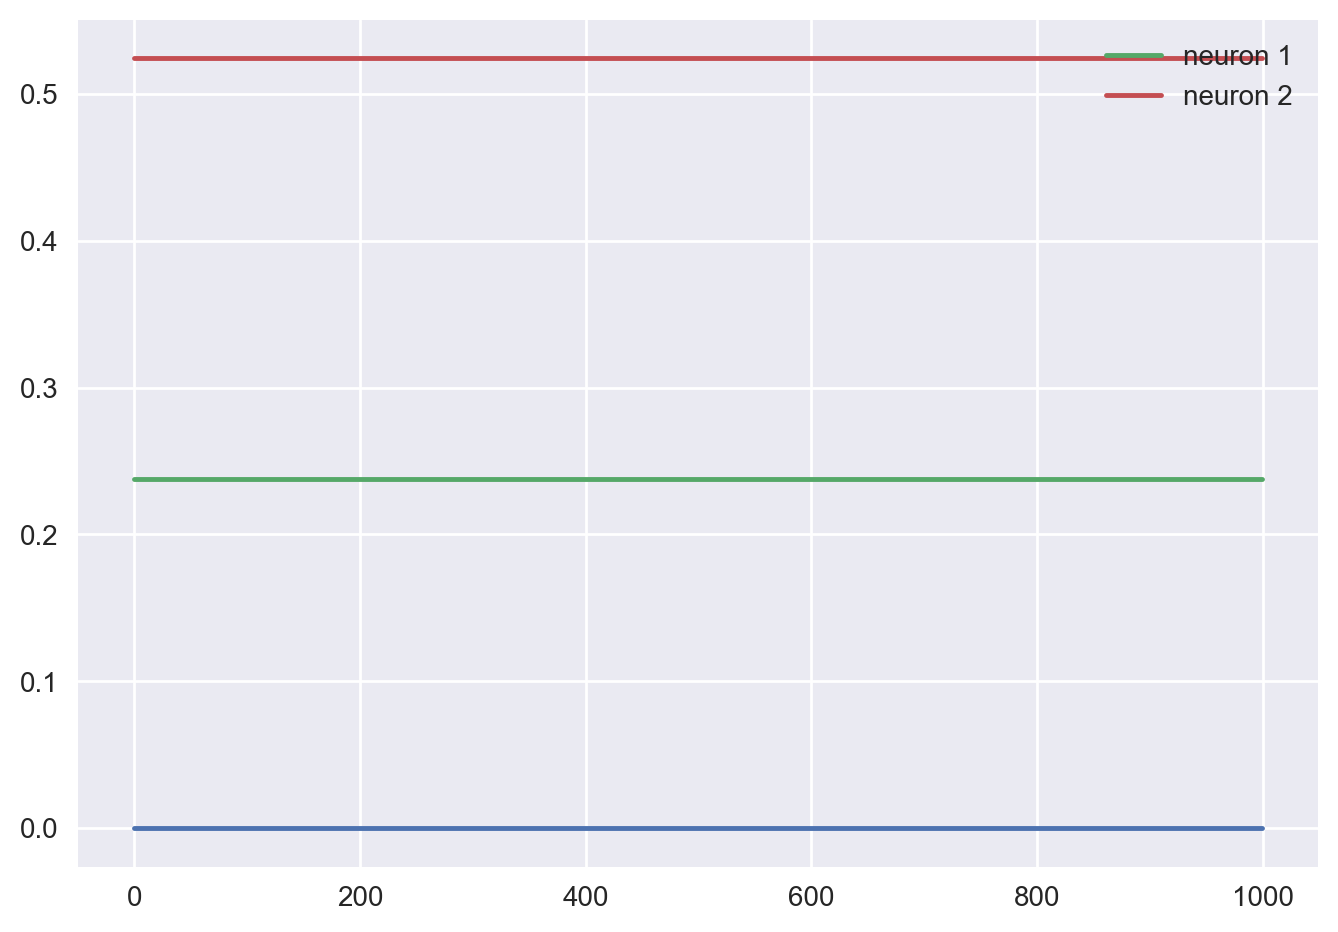

In [353]:
# simple STDP simulation and plot
I = np.zeros((1000,2))
I[:300,0] = 1
I[800:900,0] = 1
I[300:700,1] = 4
weights_history, spk_out, mem_out, _ , neuron= base_simulation(pars, I, LIFNeuron, STDP_rule, N_pre=2)
plt.figure()
#plt.plot(mem_out)
plt.plot(spk_out)
plt.plot(weights_history[1:,0,0], label='neuron 1')
plt.plot(weights_history[1:,0,1], label='neuron 2')
plt.legend()
plt.show()


# i pesi non si stanno comportando come dovrebbero, ma adesso non mi importa che il risultato sia giusto ma solo che il codice giri.